# Data Mining Project

## Knowledge Extraction Pipeline

This notebooks defines a series os steps that end up in the production of the desired prediction, including Data Preparation, Modeling and Evaluation, according to CRISP-DM guidelines.
For information regarding Data Understanding, please refer to [Data Understanding](data_understanding.ipynb).

#### Dependencies

The code block below defines the major dependencies for the project.
To make sure you are set up, please run the following command in order to update dependencies:

```bash
pip install -r requirements.txt
```

We chose to use a set of technologies that we were familiar with and should be adequate for the problem at hand.
These include **sklearn** to model the data, **matplotlib** and **seaborn** to create graphics and **pandas** to better read the data.

In [7]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os

DATA_PATH = 'data'
DATA_TEAMS = 'teams.csv'
DATA_COACHES = 'coaches.csv'
DATA_PLAYERS = 'players.csv'
DATA_AWARDS = 'awards_players.csv'
DATA_PLAYERS_TEAMS = 'players_teams.csv'
DATA_SERIES_POST = 'series_post.csv'
DATA_TEAMS_POST = 'teams_post.csv'


## Data Understanding


### Related Work

Sports related predictions are a fairly common problem.
It serves of value for different entities, such as bookmakers, sports teams and fans.
This fact together with the recent increase in the availability of data justifies the employment of machine learning techniques to the problem. [<a href="#ref1">1</a>]

The problem of predicting the outcome of a basketball game has been approached in different ways.
A common take on the subject is to try and predict the outcome of a single game, as opposed to the set of qualified teams.
Nevertheless, some similarities found between solutions were the use of machine learning algorithms and of similar attributes (rebounds, free throws, turn overs, etc).

In [<a href="#ref2">2</a>] the authors identify the characteristic high-dimensionality of the problem, and employ a Support Vector Machine Algorithm that predicted the outcome of a game with 88% accuracy.

Among common attributes, the author of [<a href="#ref3">3</a>] found that the most important ones were Free Throws, Offensive Rebounds, Turn Overs and +/- (Plus Minus).
They were also able to predict the champion team with an 86% recall using Random Forest.


Finally, the authors of [<a href="#ref4">4</a>] used a Naive Bayes Classifier to predict the outcome of games with 67% accuracy.

## Data Preparation

TODO: add text about data set (summary from data exploration)

In [8]:
awards_df = pd.read_csv(os.path.join(DATA_PATH, DATA_AWARDS))
awards_df.drop(columns=['lgID'], inplace=True)

coaches_df = pd.read_csv(os.path.join(DATA_PATH, DATA_COACHES))
coaches_df['coachWLRatio'] = (coaches_df['won'] + coaches_df['post_wins']) / (coaches_df['lost'] + coaches_df['post_losses'])
coaches_df.drop(columns=['lgID', 'stint', 'won', 'lost', 'post_wins', 'post_losses'], inplace=True)

players_teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_PLAYERS_TEAMS))
players_df = pd.read_csv(os.path.join(DATA_PATH, DATA_PLAYERS))
series_post_df = pd.read_csv(os.path.join(DATA_PATH, DATA_SERIES_POST))
teams_post_df = pd.read_csv(os.path.join(DATA_PATH, DATA_TEAMS_POST))

teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_TEAMS))
# Remove unnecessary info
teams_df.drop(columns=['franchID', 'lgID', 'divID', 'rank', 'seeded', 'firstRound', 'semis', 'finals', 'name'], inplace=True)
# Remove nulls
teams_df.drop(columns=["tmORB","tmDRB","tmTRB","opptmORB","opptmDRB","opptmTRB", 'attend', 'arena'], inplace=True)
# Collapse wins & losses into one feature
teams_df['teamWLRatio'] = teams_df['won'] / teams_df['lost']
teams_df.drop(columns=['won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min'], inplace=True)
# Clean up rebounds
teams_df.drop(columns=['o_oreb', 'o_dreb', 'd_dreb', 'd_oreb'], inplace=True)

print(teams_df.shape)
print(teams_df.columns)
teams_df.head()

merged_df = teams_df[['year', 'tmID', 'playoff']]

(142, 31)
Index(['year', 'tmID', 'confID', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_reb',
       'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'teamWLRatio'],
      dtype='object')


In [9]:
# Merge Tables

# Merge teams
teams_df['year'] = teams_df['year'] + 1
teams_df['playoff_prev'] = teams_df['playoff']
teams_df.drop(columns=['playoff'], inplace=True)
merged_df = pd.merge(merged_df, teams_df, on=['year', 'tmID'], how='left')

#merged_df = pd.merge(merged_df, players_teams_df, on=['tmID','year'], how='left')

# merged_df = pd.merge(merged_df, awards_df, on=['playerID', 'year'], how='left')

# Merge coaches
coaches_temp = coaches_df[['coachID', 'year', 'tmID']]
merged_df = pd.merge(merged_df, coaches_temp, on=['year', 'tmID'], how='left')
coaches_df['year'] = coaches_df['year'] + 1
coaches_df.drop(columns=['tmID'], inplace=True)
merged_df = pd.merge(merged_df, coaches_df, on=['year', 'coachID'], how='left')
# fill with mean
merged_df['coachWLRatio'] = merged_df['coachWLRatio'].fillna(merged_df['coachWLRatio'].mean())

'''
# Merge Series_post and Teams twice (for winning and losing teams)
# using "tmIDWinner" and "lgIDWinner" keys for winning teams
winning_teams_df = pd.merge(series_post_df, teams_df, left_on=['year', 'tmIDWinner', 'lgIDWinner'], right_on=[
                            'year', 'tmID', 'lgID'], suffixes=('', '_winning'), how='inner')
# using "tmIDLoser" and "lgIDLoser" keys for losing teams
losing_teams_df = pd.merge(series_post_df, teams_df, left_on=['year', 'tmIDLoser', 'lgIDLoser'], right_on=[
                           'year', 'tmID', 'lgID'], suffixes=('', '_losing'), how='inner')

'''
# Merge Teams_post and Teams using the combination of "year," "tmID," and "lgID" keys
# merged_df = pd.merge(merged_df, teams_post_df, on=['year', 'tmID', 'lgID'], how='inner')

players_df.rename(columns={"bioID": "playerID"}, inplace=True)
# merged_df = pd.merge(merged_df, players_df, on=['playerID'], how='inner')

# You now have a consolidated DataFrame with all the merged data
# You can continue to perform any additional analysis or transformations needed

# Save the result to a new CSV file
merged_df.to_csv(os.path.join(DATA_PATH, 'merged_data.csv'), index=False)


df = merged_df
df.head()

,year,tmID,playoff,confID,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,...,d_asts,d_pf,d_stl,d_to,d_blk,d_pts,teamWLRatio,playoff_prev,coachID,coachWLRatio
0,9,ATL,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,meadoma99w,1.351403
1,10,ATL,Y,EA,895.0,2258.0,542.0,725.0,202.0,598.0,...,684.0,726.0,310.0,561.0,134.0,2879.0,0.133333,N,meadoma99w,0.133333
2,1,CHA,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dunntr01wc,1.351403
3,2,CHA,Y,EA,812.0,1903.0,431.0,577.0,131.0,386.0,...,596.0,596.0,259.0,426.0,123.0,2429.0,0.333333,N,donovan99w,0.391304
4,3,CHA,Y,EA,746.0,1780.0,410.0,528.0,153.0,428.0,...,443.0,579.0,257.0,447.0,124.0,2009.0,1.285714,Y,donovan99w,1.222222


TODO: add text about which transformations were made

In [10]:
df['playoff'] = df['playoff'].eq('Y').mul(1)
df = df.select_dtypes(['number']) # Remove later
df.dropna(axis=0, inplace=True)
df.head()
print(df.shape)

(140, 30)


## Modeling and Evaluation

The following block defines general utility function that will serve to model the data and access results.

We chose to create the training and testing subsets in a temporal fashion.
The reason being it wouldn't make sense to scatter data from different years, since our game data is chronological.
As an example, we can train the model with the first 9 years and use the 10th and last to test the model's predictions.

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

test_year = 10

train_df = df[df['year'] < test_year]
test_df = df[df['year'] == test_year]

X_train = train_df.drop('playoff', axis=1)
y_train = train_df['playoff']

X_test = test_df.drop('playoff', axis=1)
y_test = test_df['playoff']

'''Get metrics for the prediction'''
def getMetrics(model, testing_inputs, testing_classes):
    model.score(testing_inputs, testing_classes)

    y_pred = model.predict(testing_inputs)

    accuracy = accuracy_score(testing_classes, y_pred)
    precision = precision_score(testing_classes, y_pred)
    recall = recall_score(testing_classes, y_pred)
    f1 = f1_score(testing_classes, y_pred)
    return (y_pred, accuracy, precision, recall, f1)

'''Run a model and print results'''
def runModel(model):
    model.fit(X_train, y_train)
    _y_pred, accuracy, precision, recall, f1 = getMetrics(model, X_test, y_test)

    print(f"Accuracy: {round(accuracy * 100, 2)}%")
    print(f"Precision: {round(precision * 100, 2)}%")
    print(f"Recall: {round(recall * 100, 2)}%")
    print(f"F1-measure: {round(f1 * 100, 2)}%")

    cm = confusion_matrix(y_test, _y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 81.25%
Precision: 80.0%
Recall: 88.89%
F1-measure: 84.21%


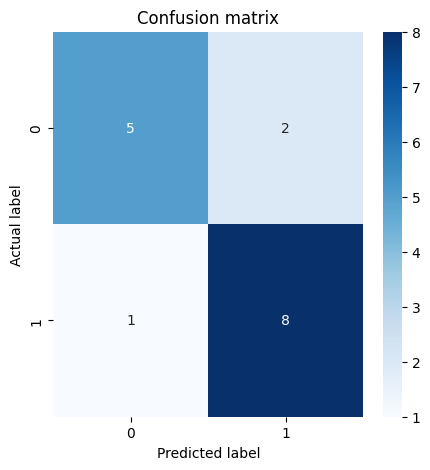

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=2)

#model = GaussianNB()
runModel(model)


### References

<a id="ref1"></a> [1] Bunker, R. P., & Thabtah, F. (2019). A machine learning framework for sport result prediction. Applied Computing and Informatics, 15(1), 27-33. https://doi.org/10.1016/j.aci.2017.09.005

<a id="ref2"></a> [2] Jadhav, A. (2016). Predicting the NBA playoff using SVM. CORE. https://core.ac.uk/display/230494997?utm_source=pdf&utm_medium=banner&utm_campaign=pdf-decoration-v1

<a id="ref3"></a> [3] Jien, O. W. (2022, January 5). Prediction model for NBA championship by Machine Learning. Medium. https://medium.com/@weinjien99/prediction-model-for-nba-championship-by-machine-learning-8e8884ea72c8

<a id="ref4"></a> [4] D. Miljković, L. Gajić, A. Kovačević and Z. Konjović, "The use of data mining for basketball matches outcomes prediction," IEEE 8th International Symposium on Intelligent Systems and Informatics, Subotica, Serbia, 2010, pp. 309-312, doi: 10.1109/SISY.2010.5647440.
